In [2]:
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import spacy
import re
import ast
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models 
import bertopic

from tqdm import tqdm

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize

from gensim import corpora
from gensim.models import CoherenceModel,LdaModel,LsiModel
from sklearn.metrics import silhouette_samples, silhouette_score

from itertools import chain

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec, Phrases, KeyedVectors
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess
from nltk.corpus import wordnet
# from pattern.en import pluralize, singularize
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

c:\Users\David-Desktop\miniconda3\envs\NLP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DATA EXPLORATION & PREPROCESSING


In [3]:
# data loading
dataset = pd.read_json("News_Category_Dataset_v2.json", lines=True, dtype={"headline": str})
dataset.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [4]:
def dummy_word_split(texts):
    """Function identifying words in a sentence in a really dummy way.

        Argument:
            - texts (list of str): a list of raw texts in which we'd like to identify words

        Return:
            - list of list containing each word separately.
    """
    texts_out = []
    for text in texts:
        texts_out.append(text.split(" "))

    return texts_out

In [5]:
def compute_word_occurences(texts):
    """You have to define this function yourself. """

    words = itertools.chain.from_iterable(texts)

    word_count = pd.Series(words).value_counts()
    word_count = pd.DataFrame({"Word": word_count.index, "Count": word_count.values})

    return word_count

In [6]:
splitted_texts = dummy_word_split(dataset["headline"].tolist())
compute_word_occurences(splitted_texts).head(20)

,Word,Count
0,The,47803
1,To,38569
2,A,24839
3,In,24141
4,Of,22956
5,For,18788
6,Is,16823
7,And,15137
8,On,13642
9,With,12556


La plupart des mots fréquents semblent être des stopwords courants, tels que "the," "to," "a," "in," etc. Ces mots n'apportent généralement pas beaucoup de sens individuellement et peuvent être éliminés lors du preprocessing.

Des variations de cas (majuscules et minuscules) pour des mots comme "The" et "the." La normalisation en minuscules peut être utile pour traiter ces variations.

In [7]:
def check_data_quality(texts):
    """Check wheter all the dataset is conform to the expected behaviour."""
    assert all([isinstance(t, str) for t in texts]), "Input data contains something different than strings."
    assert all([t != np.nan for t in texts]), "Input data contains NaN values."

    return True

In [8]:
def force_format(texts):
    return [str(t) for t in texts]

In [9]:
texts = force_format(dataset["headline"])
print(f"Is the dataset passing our data quality check?\n{check_data_quality(texts)}")

Is the dataset passing our data quality check?
True


In [10]:
texts[:5]

['There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 "Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song",
 'Hugh Grant Marries For The First Time At Age 57',
 "Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork",
 'Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog']

In [11]:
def filter_text(texts_in):
    """Removes incorrect patterns from a list of texts, such as hyperlinks, bullet points and so on"""

    texts_out = re.sub(r'https?:\/\/[A-Za-z0-9_.-~\-]*', ' ', texts_in, flags=re.MULTILINE)
    texts_out = re.sub(r'[(){}\[\]<>]', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'&amp;#.*;', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'&gt;', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'â€™', "'", texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'\s+', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'&#x200B;', ' ', texts_out, flags=re.MULTILINE)
    # Mail regex
    # This regex is correct but WAY TOO LONG to process. So we skip it with a simpler version
    # texts_out = re.sub(r"(?i)(?:[a-z0-9!#$%&'*+\/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+\/=?^_`{|}~-]+)*|\"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*\")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])", '', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+\.[a-zA-Z0-9-_.]+', '', texts_out, flags=re.MULTILINE)
    # Phone regex
    # This regex is correct but WAY TOO LONG to process. So we skip it with a simpler version
    # texts_out = re.sub(r".*?(\(?\d{3}\D{0,3}\d{3}\D{0,3}\d{4}).*?", '', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r"\(?\d{3}\D{0,3}\d{3}\D{0,3}\d{4}", '', texts_out, flags=re.MULTILINE)
    # Remove names in twitter
    texts_out = re.sub(r'@\S+( |\n)', '', texts_out, flags=re.MULTILINE)

    # Remove starts commonly used on social media
    texts_out = re.sub(r'\*', '', texts_out, flags=re.MULTILINE)
    return texts_out


In [12]:
texts = [filter_text(t) for t in texts]
texts[:5]

['There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 "Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song",
 'Hugh Grant Marries For The First Time At Age 57',
 "Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork",
 'Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog']

In [13]:
def sent_to_words(sentences):
    """Converts sentences to words.

    Convert sentences in lists of words while removing the accents and the punctuation.

    @param:
        sentences: a list of strings, the sentences we want to convert
    @return
        A list of words' lists.
    """
    for sentence in tqdm(sentences):
        yield (simple_preprocess(str(sentence), deacc=True))


In [14]:
texts = list(sent_to_words(texts))
texts[:2]

100%|██████████| 200853/200853 [00:04<00:00, 44365.89it/s]


[['there',
  'were',
  'mass',
  'shootings',
  'in',
  'texas',
  'last',
  'week',
  'but',
  'only',
  'on',
  'tv'],
 ['will',
  'smith',
  'joins',
  'diplo',
  'and',
  'nicky',
  'jam',
  'for',
  'the',
  'world',
  'cup',
  'official',
  'song']]

In [15]:
def get_stopwords(additional_stopwords=[]):
    """Return a list of english stopwords, that can be augmented by using a stopwords file or a list of stopwords

    Args:
        filepath (str, optional): path to a text file where each line is a stopword
        additional_stopwords (list of str, optional): list of string representing stopwords
    Returns:
        List of strings representing stopwords
    """
    # Loading standard english stop words
    with open('stopwords.txt', 'r') as f:
        stop_w = f.readlines()
    stopwords = [s.rstrip() for s in stop_w]

    # Adding stop words from sklearn
    stopwords = list(text.ENGLISH_STOP_WORDS.union(stopwords))

    # Adding words from a list if specified
    if additional_stopwords:
        stopwords += additional_stopwords

    # Removing duplicates
    stopwords = list(set(stopwords))

    # Removing some \n that were included in the native stopwords of sklearn ... WHY?
    stopwords = [s.replace("\n", "") for s in stopwords]

    stopwords = sorted(stopwords, key=str.lower)

    return stopwords


In [16]:
#En plus des stopwords donnésn, on ajoute Trump, Photo et Video
stopwords = get_stopwords(additional_stopwords=["trump", "photo", "video"])

texts = [[word for word in txt if word not in stopwords] for txt in tqdm(texts)]

100%|██████████| 200853/200853 [00:10<00:00, 19224.44it/s]


In [17]:
texts[:5]

[['mass', 'shootings', 'texas', 'week', 'tv'],
 ['smith',
  'joins',
  'diplo',
  'nicky',
  'jam',
  'world',
  'cup',
  'official',
  'song'],
 ['hugh', 'grant', 'marries', 'time', 'age'],
 ['jim',
  'carrey',
  'blasts',
  'castrato',
  'adam',
  'schiff',
  'democrats',
  'artwork'],
 ['julianna', 'margulies', 'donald', 'poop', 'bags', 'pick', 'dog']]

In [18]:
def create_bigrams(texts, bigram_count=15, threshold=10, convert_sent_to_words=False, as_str=True):
    """Identify bigrams in texts and return the texts with bigrams integrated"""
    if convert_sent_to_words:
        texts = list(sent_to_words(texts))

    bigram_model = Phraser(Phrases(texts, min_count=bigram_count, threshold=threshold))

    if as_str:
        return [" ".join(bigram_model[t]) for t in texts]

    else:
        return [bigram_model[t] for t in texts]

In [19]:
texts = create_bigrams(texts)
texts[:5]

['mass_shootings texas week tv',
 'smith joins diplo nicky jam world_cup official song',
 'hugh grant marries time age',
 'jim_carrey blasts castrato adam schiff democrats artwork',
 'julianna margulies donald poop bags pick dog']

In [20]:
! python -m spacy download en_core_web_md

     ---------------------------------------- 0.0/45.7 MB ? eta -:--:--
     --- ------------------------------------ 4.5/45.7 MB 95.6 MB/s eta 0:00:01
     -------- ----------------------------- 10.1/45.7 MB 106.9 MB/s eta 0:00:01
     ------------ ------------------------- 15.6/45.7 MB 108.8 MB/s eta 0:00:01
     ----------------- -------------------- 21.4/45.7 MB 108.8 MB/s eta 0:00:01
     --------------------- ---------------- 26.4/45.7 MB 108.8 MB/s eta 0:00:01
     -------------------------- ----------- 32.1/45.7 MB 110.0 MB/s eta 0:00:01
     ------------------------------- ------ 37.3/45.7 MB 131.2 MB/s eta 0:00:01
     ----------------------------------- -- 42.7/45.7 MB 129.5 MB/s eta 0:00:01
     -------------------------------------  45.7/45.7 MB 108.8 MB/s eta 0:00:01
     -------------------------------------  45.7/45.7 MB 108.8 MB/s eta 0:00:01
     -------------------------------------  45.7/45.7 MB 108.8 MB/s eta 0:00:01
     --------------------------------------- 45.

DEPRECATION: https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.2.0/en_core_web_md-3.2.0-py3-none-any.whl#egg=en_core_web_md==3.2.0 contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617


In [21]:
def lemmatize_texts(texts,
                    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'],
                    forbidden_postags=[],
                    as_sentence=False,
                    get_postags=False,
                    spacy_model=None):
    POS_map = {
        'NOUN': 'noun',
        'ADJ': 'adjective',
        'VERB': 'verb',
        'ADV': 'adverb'
    }
    """Lemmatize a list of texts.

            Please refer to https://spacy.io/api/annotation for details on the allowed
        POS tags.
        @params:
            - texts_in: a list of texts, where each texts is a string
            - allowed_postags: a list of part of speech tags, in the spacy fashion
            - as_sentence: a boolean indicating whether the output should be a list of sentences instead of a list of word lists
        @return:
            - A list of texts where each entry is a list of words list or a list of sentences
        """
    texts_out = []

    if allowed_postags and forbidden_postags:
        raise ValueError("Can't specify both allowed and forbidden postags")

    if forbidden_postags:
        allowed_postags = list(set(POS_map.keys()).difference(set(forbidden_postags)))

    if not spacy_model:
        print("Loading spacy model")
        spacy_model = spacy.load('en_core_web_md')

    print("Beginning lemmatization process")
    total_steps = len(texts)

    docs = spacy_model.pipe(texts)

    for i, doc in tqdm(enumerate(docs), total=total_steps):
        if get_postags:
            texts_out.append(["_".join([token.lemma_, token.pos_]) for token in doc if token.pos_ in allowed_postags])
        else:
            texts_out.append(
                [token.lemma_ for token in   doc if token.pos_ in allowed_postags])

    if as_sentence:
        texts_out = [" ".join(text) for text in texts_out]

    return texts_out


In [37]:
l_texts = lemmatize_texts(texts,
                allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'X', 'PROPN'],
                get_postags=False)

Loading spacy model
Beginning lemmatization process


100%|██████████| 200853/200853 [03:39<00:00, 917.00it/s] 


In [ ]:
occurences = compute_word_occurences(l_texts)
occurences.head()

,Word,Count
0,photo,9870
1,make,4891
2,woman,4546
3,donald,4474
4,year,4117


In [ ]:
dataset['category'].nunique()

41


On a 41 catégorie différentes dans notre dataset.


c:\Users\David-Desktop\miniconda3\envs\NLP\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])


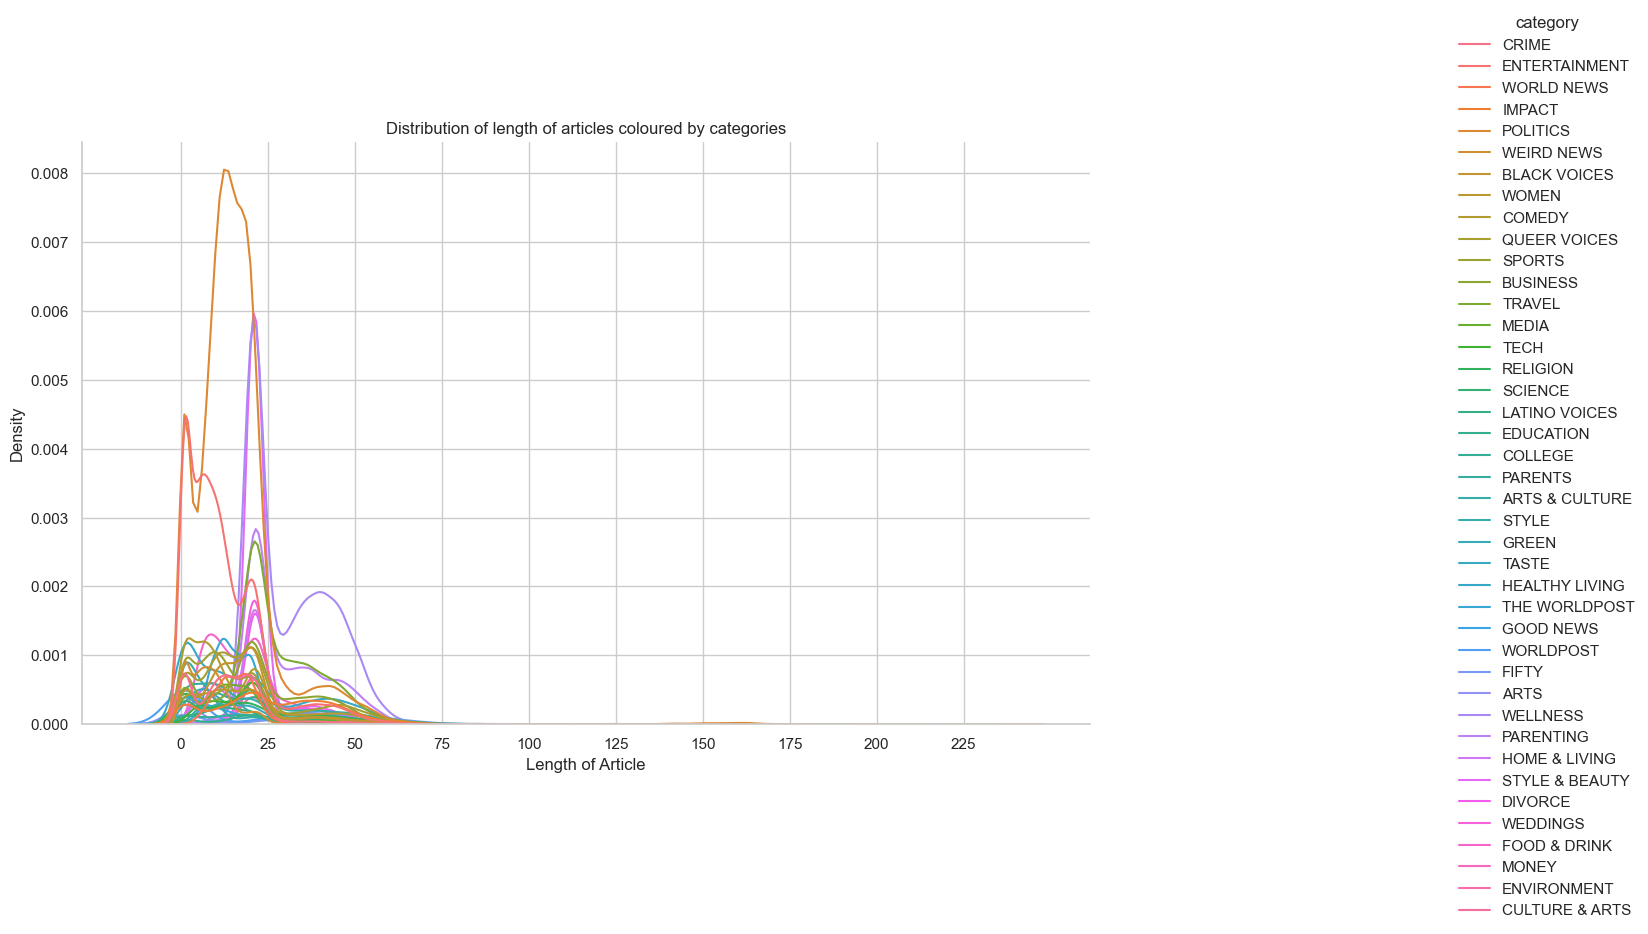

In [ ]:
sns.set(style = 'whitegrid')
figu = sns.displot(x = dataset['short_description'].str.split(' ').apply(len), hue = dataset['category'], kind = 'kde')
figu.figure.set_size_inches(18,7)
figu.set(title = f'Distribution of length of articles coloured by categories', xlabel = 'Length of Article', xticks = range(0,250,25))
plt.show()

In [ ]:
# Download the NLTK resources (run this once)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to C:\Users\David-
[nltk_data]     Desktop\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\David-Desktop\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
text = ' '.join(dataset['headline'])  # Combine all headlines into one string

# Tokenize the text and get part-of-speech tags
tokens = word_tokenize(text)
pos_tags = pos_tag(tokens)

# Filter words based on their part-of-speech tags
nouns = [word for word, pos in pos_tags if pos.startswith('N')]
verbs = [word for word, pos in pos_tags if pos.startswith('V')]
adjectives = [word for word, pos in pos_tags if pos.startswith('J')]

# Display the most common words for each category
common_nouns = pd.Series(nouns).value_counts().head(10)
common_verbs = pd.Series(verbs).value_counts().head(10)
common_adjectives = pd.Series(adjectives).value_counts().head(10)

print("Top 10 Most Common Nouns:")
print(common_nouns)

print("\nTop 10 Most Common Verbs:")
print(common_verbs)

print("\nTop 10 Most Common Adjectives:")
print(common_adjectives)


Top 10 Most Common Nouns:
A         17458
Trump     12533
PHOTOS     9039
New        8462
How        6486
Donald     4586
’          4515
Day        4391
Is         4210
VIDEO      4142
dtype: int64

Top 10 Most Common Verbs:
Is      13415
's       5876
Do       4037
Are      4010
Be       3730
Have     2731
s        1842
Make     1740
Get      1693
Need     1564
dtype: int64

Top 10 Most Common Adjectives:
More        2930
Best        1125
Other       1092
Most        1026
Last         785
American     725
Good         695
Own          531
Much         502
Next         462
dtype: int64


## Chargement des données 

In [ ]:
def force_format(texts):
    return [str(t) for t in texts]

def compute_word_occurences(texts):
    words = itertools.chain.from_iterable(texts)
    word_count = pd.Series(words).value_counts()
    word_count = pd.DataFrame({"Word": word_count.index, "Count": word_count.values})
    return word_count

def get_l_texts(text_file): #text_file is a .txt file from preprocessing to avoid doing it again
    l_texts=[]
    with open(text_file, "r") as f:
        line = f.readlines()
        list_line = [l.strip() for l in line]
        for l in list_line:
            l_texts.append(ast.literal_eval(l))
    return l_texts

In [40]:
dataset = pd.read_json("News_Category_Dataset_v2.json", lines=True, dtype={"headline": str})
texts = force_format(dataset["headline"])
#l_texts = get_l_texts("l_texts.txt")
print(l_texts[:10],"\n",texts[:10],"\n",dataset["headline"][:10])

[['be', 'Mass', 'Shootings', 'Texas', 'last', 'Week', 'only', 'tv'], ['Smith', 'join', 'Diplo', 'Nicky', 'Jam', 'World', 'Cup', 'Official', 'Song'], ['Hugh', 'Grant', 'Marries', 'First', 'Time', 'age'], ['Jim', 'Carrey', 'Blasts', 'Castrato', 'Adam', 'Schiff', 'Democrats', 'New', 'artwork'], ['Julianna', 'Margulies', 'use', 'Donald', 'Trump', 'Poop', 'Bags', 'pick', 'dog'], ['Morgan', 'Freeman', 'devastate', 'Sexual', 'Harassment', 'Claims', 'undermine', 'Legacy'], ['Donald', 'Trump', "lovin'", 'New', 'McDonald', 'Jingle', 'tonight', 'show', 'bit'], ['watch', 'Amazon', 'Prime', '’', 'New', 'week'], ['Mike', 'Myers', 'reveal', 'like', 'do', 'Fourth', 'Austin', 'Powers', 'Film'], ['watch', 'Hulu', '’', 'New', 'week']] 
 ['There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV', "Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song", 'Hugh Grant Marries For The First Time At Age 57', "Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork", 

In [41]:
# Create a dictionary
dictionary = corpora.Dictionary(l_texts)
# Create a corpus
corpus = [dictionary.doc2bow(text) for text in l_texts]

print("Number of unique tokens: {}".format(len(dictionary)))
print("Number of documents: {}".format(len(corpus)))

Number of unique tokens: 64889
Number of documents: 200853


## Pour les modèles disponibles dans la librairie gensim

### LDA

In [42]:
result={"num_topics":[], "coherence_score_cv":[],"coherence_score_npmi":[]}

for n in range(50, 65):
    lda_model = LdaModel(corpus, num_topics=n, id2word=dictionary)
    coherence_model_cv= CoherenceModel(model=lda_model, texts=l_texts, dictionary=dictionary, coherence='c_v')
    coherence_score_cv = coherence_model_cv.get_coherence()
    coherence_model_npmi= CoherenceModel(model=lda_model, texts=l_texts, dictionary=dictionary, coherence='c_npmi')
    coherence_score_npmi = coherence_model_npmi.get_coherence()
    print("Number of topics: ", n, " Coherence Score: ", coherence_score_npmi,coherence_score_cv)
    result["num_topics"].append(n)
    result["coherence_score_cv"].append(coherence_score_cv)
    result["coherence_score_npmi"].append(coherence_score_npmi)

Number of topics:  50  Coherence Score:  -0.25152404060826394 0.4663035372760885
Number of topics:  51  Coherence Score:  -0.2586989353770912 0.4744257099667037
Number of topics:  52  Coherence Score:  -0.26583126911899996 0.4866362463185982
Number of topics:  53  Coherence Score:  -0.2505694366420342 0.4640809608221701
Number of topics:  54  Coherence Score:  -0.267127293060826 0.4864829470647558
Number of topics:  55  Coherence Score:  -0.26615568488221164 0.4886801105240594
Number of topics:  56  Coherence Score:  -0.2665527948625465 0.4858229467150847
Number of topics:  57  Coherence Score:  -0.26193152420765864 0.4781788373564487
Number of topics:  58  Coherence Score:  -0.2745298416759977 0.497150317260975
Number of topics:  59  Coherence Score:  -0.27069716892983214 0.490973106544864
Number of topics:  60  Coherence Score:  -0.27229917458090586 0.4941278999869948
Number of topics:  61  Coherence Score:  -0.27696249521545985 0.5013417299185444
Number of topics:  62  Coherence Sco

In [43]:
optimal_n=result["num_topics"][np.argmax(result["coherence_score_cv"])]
lda_model = LdaModel(corpus, num_topics=optimal_n, id2word=dictionary)
coherence_model_cv= CoherenceModel(model=lda_model, texts=l_texts, dictionary=dictionary, coherence='c_v')
coherence_score_cv = coherence_model_cv.get_coherence()
coherence_model_npmi= CoherenceModel(model=lda_model, texts=l_texts, dictionary=dictionary, coherence='c_npmi')
coherence_score_npmi = coherence_model_npmi.get_coherence()
print("Optimal number of topics: ", optimal_n, " Coherence Score: ", coherence_score_npmi,coherence_score_cv)

Optimal number of topics:  62  Coherence Score:  -0.2748903847133842 0.499002653541693


In [44]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

c:\Users\David-Desktop\miniconda3\envs\NLP\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
49    -0.014491 -0.075655       1        1  3.002718
33     0.291164  0.113833       2        1  2.436577
36     0.092963  0.052598       3        1  2.354379
35     0.139806 -0.005204       4        1  2.300813
52     0.040081  0.134785       5        1  2.209451
...         ...       ...     ...      ...       ...
45    -0.074832  0.012184      58        1  1.283018
43    -0.038809 -0.050133      59        1  1.273377
18    -0.056690  0.039454      60        1  1.225867
59    -0.087187  0.013287      61        1  1.170469
12    -0.048393 -0.072204      62        1  1.098573

[62 rows x 5 columns], topic_info=               Term          Freq         Total Category  logprob  loglift
2452          photo  25337.000000  25337.000000  Default  30.0000  30.0000
29              New  12461.000000  12461.000000  Default  29.0000  29.0000
389           video  11034.000000  11034.000000  Default  28.0000  28.0000
371            make   9443.000000   9443.000000  Default  27.0000  27.0000
142            look   8276.000000   8276.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
3505           Cash    168.658287    170.420931  Topic62  -4.4644   4.5008
2650  Controversial    162.782769    164.545414  Topic62  -4.4998   4.5004
5225     researcher    154.475461    156.238105  Topic62  -4.5522   4.4998
5224     prediction    148.782942    150.545586  Topic62  -4.5897   4.4994
4982        Rolling    114.891478    116.654122  Topic62  -4.8482   4.4959

[1927 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
294      15  0.998001      '
684      27  0.999703      -
1600     13  0.993328      .
3542      4  0.986984    4th
4896      2  0.981198     90
...     ...       ...    ...
2134     25  0.994859  write
3502     24  0.997169  wrong
614      21  0.999560   year
318       6  0.992511    yet
1295     34  0.994140  young

[2021 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[50, 34, 37, 36, 53, 32, 38, 49, 6, 45, 35, 8, 3, 31, 23, 5, 52, 56, 7, 17, 2, 22, 62, 30, 42, 4, 18, 57, 15, 59, 39, 26, 10, 40, 47, 14, 48, 24, 51, 12, 11, 9, 54, 25, 1, 16, 28, 27, 55, 58, 61, 21, 29, 41, 43, 20, 33, 46, 44, 19, 60, 13])

### LSI


In [ ]:
lsi_model = LsiModel(corpus, num_topics=optimal_n, id2word=dictionary)
coherence_model_cv= CoherenceModel(model=lsi_model, texts=l_texts, dictionary=dictionary, coherence='c_v')
coherence_score_cv = coherence_model_cv.get_coherence()
coherence_model_npmi= CoherenceModel(model=lsi_model, texts=l_texts, dictionary=dictionary, coherence='c_npmi')
coherence_score_npmi = coherence_model_npmi.get_coherence()
print("Number of topics: ", optimal_n, " Coherence Score: ", coherence_score_npmi,coherence_score_cv)

c:\Users\David-Desktop\miniconda3\envs\NLP\lib\site-packages\gensim\models\lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(
c:\Users\David-Desktop\miniconda3\envs\NLP\lib\site-packages\scipy\linalg\_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape[0], m.shape[1], k - 1, m.dtype.char)) * m
c:\Users\David-Desktop\miniconda3\envs\NLP\lib\site-packages\scipy\linalg\_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape[0], m.shape[1], k - 1, m.dtype.char)) * m
c:\Users\David-Desktop\miniconda3\envs\NLP\lib\site-packages\scipy\linalg\_special_matrices.py:154: DeprecationWarnin

Number of topics:  60  Coherence Score:  -0.03706901786546233 0.2307061938198717


In [ ]:
# Visualize the topics
#Not possible with LSI

## BERTOPIC

In [36]:
representation=bertopic.representation.KeyBERTInspired()
model_trained_representation= bertopic.BERTopic(representation_model=representation,nr_topics=optimal_n)
topics,probs = model_trained_representation.fit_transform(dataset['headline'])

KeyboardInterrupt: 

In [ ]:
dictionary = corpora.Dictionary(l_texts)
coherence_model= CoherenceModel(model=model_trained_representation, texts=l_texts, dictionary=dictionary, coherence='c_v')
coherence_score_cv = coherence_model.get_coherence()
coherence_model= CoherenceModel(model=model_trained_representation, texts=l_texts, dictionary=dictionary, coherence='c_npmi')
coherence_score_c_npmi = coherence_model.get_coherence()
print("Coherence Score: ", coherence_score_cv,coherence_score_c_npmi)

Coherence Score:  1.0 nan


c:\Users\David-Desktop\miniconda3\envs\NLP\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\David-Desktop\miniconda3\envs\NLP\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
model_trained_representation.visualize_topics()

c:\Users\David-Desktop\miniconda3\envs\NLP\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\David-Desktop\miniconda3\envs\NLP\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [ ]:
(model_trained_representation.get_topic_info())

,Topic,Count,Name,Representation,Representative_Docs
0,-1,81507,-1_wedding_mom_ways_things,"[wedding, mom, ways, things, love, best, what,...",[What Your Wedding Style Reveals About Your Fu...
1,0,15651,0_hillary_sanders_clinton_trump,"[hillary, sanders, clinton, trump, bernie, pre...",[Mitt Romney's Top Strategist Says Hillary Cli...
2,1,14225,1_kardashian_kardashians_kylie_kim,"[kardashian, kardashians, kylie, kim, jennifer...",[Katy Perry's Movie Premiere Look: A New Take ...
3,2,7402,2_happiness_meditation_mindfulness_meditations,"[happiness, meditation, mindfulness, meditatio...","[Is Meditation The Path To True Happiness?, Da..."
4,3,5100,3_parenthood_parenting_mothers_parental,"[parenthood, parenting, mothers, parental, mot...",[Funniest Parenting Tweets: What Moms And Dads...
...,...,...,...,...,...
57,56,40,56_1915_1914_1916_wwis,"[1915, 1914, 1916, wwis, archduke, september, ...","[This Week in World War I, April 4-11, 1915, T..."
58,57,33,57_normal_new_abnormal_unusual,"[normal, new, abnormal, unusual, usual, abnorm...","[Their New Normal, Is This the New Normal?, Th..."
59,58,25,58_knives_knife_blades_chef,"[knives, knife, blades, chef, kitchen, sharpen...",[Kitchen Knives: Everything You Ever Wanted To...
60,59,23,59_rune_raidho_weekly_othala,"[rune, raidho, weekly, othala, tiwaz, eihwaz, ...","[The Weekly Rune: Othala, The Weekly Rune: Rai..."
